# Caffe LSTM Example on Sin(t) Waveform Prediction
## with Mini-Batch Training

This is a modified version of http://www.xiaoliangbai.com/2018/01/30/Caffe-LSTM-SinWaveform-Batch by Xiaoliang Bai

The linked script does not include a network definition, which makes non-reproducible, so a new network has now been added.

This demo tries to demonstrate both batch training, batch inference and realtime inference.
(Realtime inference does not utilize RNN-unrolling and computes only a single timestep)

In [1]:
import numpy as np
import math
import os
import caffe
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# change this to use GPU acceleration
#GPU_ID = 0
#caffe.set_mode_gpu()
#caffe.set_device(GPU_ID)
caffe.set_mode_cpu()

%load_ext autoreload
%autoreload 2

In [2]:
# Use the sample generator from Tensorflow Sin(t) online
def generate_sample(f = 1.0, t0 = None, batch_size = 1, predict = 50, samples = 100):
    """
    Generates data samples.

    :param f: The frequency to use for all time series or None to randomize.
    :param t0: The time offset to use for all time series or None to randomize.
    :param batch_size: The number of time series to generate.
    :param predict: The number of future samples to generate.
    :param samples: The number of past (and current) samples to generate.
    :return: Tuple that contains the past times and values as well as the future times and values. In all outputs,
             each row represents one time series of the batch.
    """
    Fs = 100.0

    T = np.empty((batch_size, samples))
    Y = np.empty((batch_size, samples))
    FT = np.empty((batch_size, predict))
    FY = np.empty((batch_size, predict))

    _t0 = t0
    for i in range(batch_size):
        t = np.arange(0, samples + predict) / Fs
        if _t0 is None:
            t0 = np.random.rand() * 2 * np.pi
        else:
            t0 = _t0 + i/float(batch_size)

        freq = f
        if freq is None:
            freq = np.random.rand() * 3.5 + 0.5

        y = np.sin(2 * np.pi * freq * (t + t0))

        T[i, :] = t[0:samples]
        Y[i, :] = y[0:samples]

        FT[i, :] = t[samples:samples + predict]
        FY[i, :] = y[samples:samples + predict]

    return T, Y, FT, FY

In [3]:
net_path = 'lstm_demo_network.train.prototxt'
inference_path = 'lstm_demo_network.deploy.prototxt'
solver_config_path = 'lstm_demo_solver.prototxt'
snapshot_prefix = 'lstm_demo_snapshot'
# Network Parameters
n_input = 1 # single input stream
n_steps = 100 # timesteps
n_hidden = 15 # hidden units in LSTM
n_outputs = 50 # predictions in future time
batch_size = 20 # batch of data
NO_INPUT_DATA = -2 # defined numeric value for network if no input data is available

## This is the network definition for training:

In [4]:
#define and save the network
from caffe import layers as L, params as P
def gen_network(n_steps,n_outputs,batch_size,n_input):
    n = caffe.NetSpec()
    # the network is trained on a time series of n_steps + n_outputs
    
    # we have input data for n_steps, which the network needs to keep tracing for n_output more steps
    # labels are given for n_output steps for loss calculation
    
    # a third input (clip) gives a mask for the first element in each time series.
    # this seems cumbersome but it allows training on series longer than the unrolled network size
    # as well as inference on infinite sequences
    
    # the data shape for caffe LSTM/RNN layers is always T x B x ... where T is the timestep and B are
    # independent data series (for example multiple batches)
    n.data, n.label, n.clip = L.Input( shape=[ dict(dim=[n_steps,batch_size,n_input]),
                                           dict(dim=[n_outputs,batch_size,n_input]),
                                           dict(dim=[n_steps+n_outputs,batch_size]) ],ntop=3)

    # the data layer size must match the size of the unrolled network, as such we concatenate with dummy-values
    # indicating that no more input data is available beyond n_steps
    n.dummy=L.DummyData( data_filler=dict(type="constant",value = NO_INPUT_DATA),
                        shape=[ dict(dim=[n_outputs,batch_size,n_input]) ] )
    n.fulldata=L.Concat(n.data, n.dummy, axis=0)
    # the lstm layer with n_hidden neurons
    n.lstm1 = L.LSTM(n.fulldata, n.clip,
                     recurrent_param = dict(num_output=n_hidden,
                                            weight_filler = dict(type='uniform',min=-0.08,max=0.08)))
    # usually followed by a fully connected output layer
    n.ip1 = L.InnerProduct(n.lstm1, num_output=1, bias_term=True, axis=2,
                           weight_filler=dict(type='gaussian',mean=0,std=0.1))
    
    # in this implementation, the loss is calculated over
    # the entire time series, not just the predicted future
    n.fulllabel=L.Concat(n.data,n.label, axis=0)
    n.loss = L.EuclideanLoss(n.ip1,n.fulllabel)
    
    ns=n.to_proto()
    return ns

ns = gen_network(n_steps, n_outputs, batch_size, n_input)
with open(net_path, 'w') as f:
    f.write(str(ns))

In [5]:
#standard Adam solver
sd = caffe.proto.caffe_pb2.SolverParameter()
sd.random_seed = 0xCAFFE
sd.train_net = net_path
sd.test_net.append(net_path)
sd.test_interval = 500  #
sd.test_iter.append(100)
sd.max_iter = 2000
sd.snapshot = 2000
sd.display = 200
sd.snapshot_prefix = snapshot_prefix
sd.solver_mode = caffe.proto.caffe_pb2.SolverParameter.CPU
sd.type = 'Adam'
sd.lr_policy = 'fixed'
sd.base_lr = 0.005

with open(solver_config_path, 'w') as f:
    f.write(str(sd))

In [6]:
### load the solver and create train and test nets
solver = caffe.get_solver(solver_config_path)

In [7]:
# Train network
niter = 2000
disp_step = 200
train_loss = np.zeros(niter) # this is for plotting, later
solver.net.params['lstm1'][1].data[n_hidden : 2 * n_hidden] = 1
# the first entry in each time series has its clip mask set to 0
clipmask = np.ones((n_steps+n_outputs,batch_size))
clipmask[0,:] = np.zeros((batch_size))
for i in range(niter):
    _, batch_x, _, batch_y = generate_sample(f=None,
                                         t0=None,
                                         batch_size=batch_size,
                                         samples=n_steps,
                                         predict=n_outputs)
    # IMPORTANT: Caffe LSTM has time in first dimension and batch in second, so
    # batched training data needs to be transposed
    batch_x = batch_x.transpose()
    batch_y = batch_y.transpose()
    solver.net.blobs['label'].data[:,:,0] = batch_y
    solver.net.blobs['data'].data[:,:,0]  = batch_x
    solver.net.blobs['clip'].data[:,:] = clipmask
    solver.step(1)
    train_loss[i] = solver.net.blobs['loss'].data
    if i % disp_step == 0:
        print "step ", i, ", loss = ", train_loss[i]
print "Finished training, iteration reached", niter

step  0 , loss =  4.94925308228
step  200 , loss =  1.51725614071
step  400 , loss =  0.932875454426
step  600 , loss =  0.511762619019
step  800 , loss =  0.428243666887
step  1000 , loss =  0.176070913672
step  1200 , loss =  0.0944289714098
step  1400 , loss =  0.297771275043
step  1600 , loss =  0.175302624702
step  1800 , loss =  0.120404481888
Finished training, iteration reached 2000


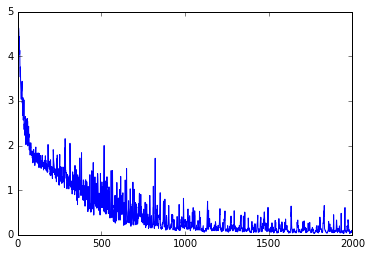

In [8]:
# plot loss value during training
plt.plot(np.arange(niter), train_loss)

In [9]:
#explicitly save snapshot if it has not been done yet
print 'saving snapshot to "%s_iter_%i.caffemodel"' % (snapshot_prefix,niter)
solver.snapshot()

saving snapshot to "lstm_demo_snapshot_iter_2000.caffemodel"


## Network testing/inference in unrolled mode on the train net

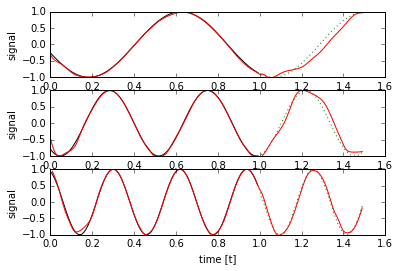

In [10]:
# Test the prediction with trained (unrolled) net
# we can change the batch size on the network at runtime, but not the number of timesteps (depth of unrolling)

n_tests = 3
batch_size = 1
solver.test_nets[0].blobs['data'].reshape(n_steps, batch_size, n_input)
solver.test_nets[0].blobs['label'].reshape(n_outputs, batch_size, n_input)
solver.test_nets[0].blobs['clip'].reshape(n_steps+n_outputs, batch_size)
solver.test_nets[0].blobs['dummy'].reshape(n_outputs, batch_size, n_input)
solver.test_nets[0].reshape()

clipmask = np.ones((n_steps+n_outputs,batch_size))
clipmask[0,:] = np.zeros(batch_size)

for i in range(1, n_tests + 1):
    plt.subplot(n_tests, 1, i)
    t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
    test_input = y.transpose()
    expected_y = expected_y.reshape(n_outputs)
    solver.test_nets[0].blobs['data'].data[:,:,0]  = test_input
    solver.test_nets[0].blobs['clip'].data[:,:] = clipmask
    solver.test_nets[0].forward()
    prediction = solver.test_nets[0].blobs['ip1'].data

    # remove the batch size dimensions
    t = t.squeeze()
    y = y.squeeze()
    next_t = next_t.squeeze()
    t2 = np.append(t,next_t)
    prediction = prediction.squeeze()
        
    plt.plot(t, y, color='black')
    plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
    plt.plot(t2, prediction, color='red')
    plt.ylim([-1, 1])
    plt.xlabel('time [t]')
    plt.ylabel('signal')
plt.show()

## Network definition for infinite length sequence inference:

In [11]:
#generate inference single time step network
def gen_deploy_network(n_input):
    n = caffe.NetSpec()
    # This network has only scalar input and output data 
    # No unrolling takes place, as such the length of each time series is 1
    # No batch processing either (batch size is 1)
    # The beginning of a new series (discarding LSTM hidden data) is indicated through the clip flag
    n.data, n.clip = L.Input( shape=[ dict(dim=[1,1,n_input]),
                                           dict(dim=[1,1]) ],ntop=2)
    n.lstm1 = L.LSTM(n.data, n.clip,
                     recurrent_param = dict(num_output=n_hidden,
                                            weight_filler = dict(type='uniform',min=-0.08,max=0.08)))
    n.ip1 = L.InnerProduct(n.lstm1, num_output=1, bias_term=True, axis=2,
                           weight_filler=dict(type='gaussian',mean=0,std=0.1))
    # n.ip1 is the output layer
    # there is no loss layer and no loss calculation
    # this network is extremely small and performant, compared to the unrolled training network
    ns=n.to_proto()
    return ns

ns = gen_deploy_network(n_input)
with open(inference_path, 'w') as f:
    f.write(str(ns))

In [12]:
# load Network with weights from previously trained network
# alternatively the network could be loaded without weights and then explicitly assigned (copied) layer by layer
print 'loading snapshot from "%s_iter_%i.caffemodel"' % (snapshot_prefix,niter)
net = caffe.Net(inference_path,caffe.TEST,weights='%s_iter_%i.caffemodel'%(snapshot_prefix,niter))

loading snapshot from "lstm_demo_snapshot_iter_2000.caffemodel"


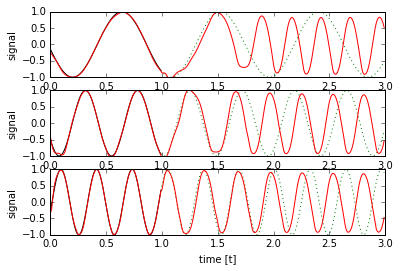

In [13]:
# the single step network can process infinite time series in a loop,
# as such we can increate n_outputs safely to have a glance at long term behaviour
#
# since this particular network was never trained on more than 50 future samples
# its not surprising it diverges a bit when running longer
n_outputs=200
for i in range(1, n_tests + 1):
    plt.subplot(n_tests, 1, i)
    t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
    expected_y = expected_y.reshape(n_outputs)

    net.blobs['clip'].data[0,0]=0
    prediction = []
    for T in range(n_steps):
        net.blobs['data'].data[0,0,0] = y[0,T]
        net.forward()
        prediction.append(net.blobs['ip1'].data[0,0,0])
        net.blobs['clip'].data[0,0]=1
        
    for T in range(n_outputs):
        # in this case we have to manually indicate to the network
        # that there is no more input data at the current time step
        net.blobs['data'].data[0,0,0] = NO_INPUT_DATA
        net.forward()
        prediction.append(net.blobs['ip1'].data[0,0,0])
        net.blobs['clip'].data[0,0]=1
        
    # remove the batch size dimensions
    t = t.squeeze()
    y = y.squeeze()
    next_t = next_t.squeeze()
    t2 = np.append(t,next_t)
    prediction = np.array(prediction)
        
    plt.plot(t, y, color='black')
    plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
    plt.plot(t2, prediction, color='red')
    plt.ylim([-1, 1])
    plt.xlabel('time [t]')
    plt.ylabel('signal')
plt.show()

Note that the unrolled network can also be used to train and test on time series longer than the unrolled network size, as long as data is fed to the network in the correct order over time and clipmask is set correctly.
However - obviously - no backpropagation is possible across the unroll_size boundaries even if the sequence is longer.